# Initialize system

In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math
from scipy.optimize import curve_fit
import pprint
import inspect 

top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths
import ePix320kM as devBoard

args = None

In [2]:
%run supportFunctions.ipynb
%run dataProcFunctions.ipynb

In [3]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = top_level,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        pciePgpEn  = False,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000400
UpTime       = 18:14:42
GitHash      = 0x1420ec1d27d3a15f69ee3c81d92a534be21a2320
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = "ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 21 Mar 2024 05:28:47 PM PDT
Builder      = dnajjar"
###################################################


In [4]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_75000018efb4ab01_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_RegisterControl.yml
Loading batcher configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_BatcherEventBuilder.yml
Loading packet register configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_75000018efb4ab01_PacketRegisters.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_ASIC_u1_PLLBypass.yml
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM

In [6]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [7]:
# Get locked lanes
time.sleep(3)
root.getLaneLocks()

# Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xffffff
ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [8]:
# Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()
    
root.enableDataRcv(False)
root.enableAllAsics(False)

descramble error
rawData length 48


# Here we select which ASIC we want to test

In [9]:
ASIC = ASIC2
ASICNUM = 2
DATADEBUG= DEBUG2
PKREG = PKREG2

root.enableAsic(ASICNUM, True)

# Run the following two cells once at initialization
The first cell might fail, that's ok. Stop it, then run the second one. Repeat if necessary.

In [16]:
lanesHackTest(root, PKREG, DATADEBUG)

PKREG.TimeoutCntLane[0]=0
PKREG.TimeoutCntLane[1]=0
PKREG.TimeoutCntLane[2]=0
PKREG.TimeoutCntLane[3]=0
PKREG.TimeoutCntLane[4]=0
PKREG.TimeoutCntLane[5]=0
PKREG.TimeoutCntLane[6]=0
PKREG.TimeoutCntLane[7]=0
PKREG.TimeoutCntLane[8]=0
PKREG.TimeoutCntLane[9]=0
PKREG.TimeoutCntLane[10]=0
PKREG.TimeoutCntLane[11]=0
PKREG.TimeoutCntLane[12]=0
PKREG.TimeoutCntLane[13]=0
PKREG.TimeoutCntLane[14]=0
PKREG.TimeoutCntLane[15]=0
PKREG.TimeoutCntLane[16]=0
PKREG.TimeoutCntLane[17]=0
PKREG.TimeoutCntLane[18]=0
PKREG.TimeoutCntLane[19]=0
PKREG.TimeoutCntLane[20]=0
PKREG.TimeoutCntLane[21]=0
PKREG.TimeoutCntLane[22]=0
PKREG.TimeoutCntLane[23]=0
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 2048)
Delta Aquisition Counter: 2048
Number of frames received: (192, 384, 2048)


In [17]:
lanesHackDisable(root, PKREG, DATADEBUG)

PKREG.TimeoutCntLane[0]=0
PKREG.TimeoutCntLane[1]=0
PKREG.TimeoutCntLane[2]=0
PKREG.TimeoutCntLane[3]=0
PKREG.TimeoutCntLane[4]=0
PKREG.TimeoutCntLane[5]=0
PKREG.TimeoutCntLane[6]=0
PKREG.TimeoutCntLane[7]=0
PKREG.TimeoutCntLane[8]=0
PKREG.TimeoutCntLane[9]=0
PKREG.TimeoutCntLane[10]=0
PKREG.TimeoutCntLane[11]=0
PKREG.TimeoutCntLane[12]=0
PKREG.TimeoutCntLane[13]=0
PKREG.TimeoutCntLane[14]=0
PKREG.TimeoutCntLane[15]=0
PKREG.TimeoutCntLane[16]=0
PKREG.TimeoutCntLane[17]=0
PKREG.TimeoutCntLane[18]=0
PKREG.TimeoutCntLane[19]=0
PKREG.TimeoutCntLane[20]=0
PKREG.TimeoutCntLane[21]=0
PKREG.TimeoutCntLane[22]=0
PKREG.TimeoutCntLane[23]=0
ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xffffff
ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490200
ASIC3: 0x540140


# Set registers and variables

In [18]:
# Set analog settings
setAnalogSettings(ASIC0)
setAnalogSettings(ASIC1)
setAnalogSettings(ASIC2)
setAnalogSettings(ASIC3)

# Set best settings - pipoclk delay
setBestSettings(REGCTRL,ASIC0, ASIC1, ASIC2, ASIC3)

#sets HSDAC device
HSDAC.enable.set(True)
#reset status
HSDAC.WFEnabled.set(False)
HSDAC.waveformSource.set(0)
HSDAC.externalUpdateEn.set(False)
HSDAC.run.set(False)

#Select reference pixel
ref_row = 100
ref_col = 150



R0 Width set to 7.808uS
R0 Delay set to 1.280uS
Acq1 Width set to 3.584uS
Acq1 Delay set to 4.864uS
-------------------------
Baseline time:    3.5839999999999996 uS
Integration time: 3.584 uS
Sampling done at: 8.448 uS
-------------------------
ASIC configured


[9401]


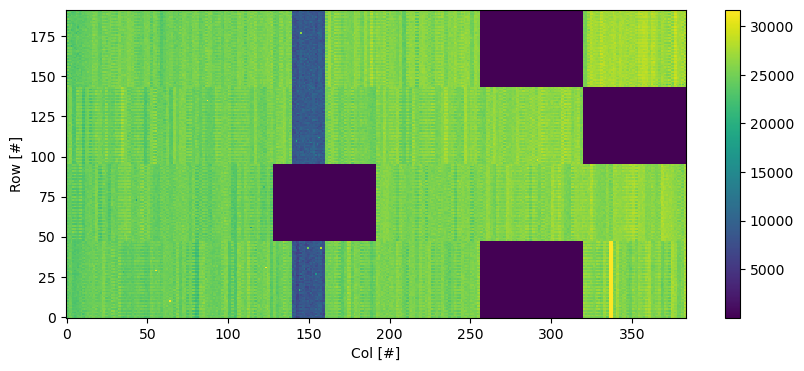

In [19]:
# Quick test to see if charge injection is working fine
chargeInj=chargeInjection(firstCol=(ref_col-10),LastCol=(ref_col+10),PulserValue=1000, AsicNum=ASICNUM)
data = readoutFrames(DATADEBUG, 1)

# Plot
plt.figure(figsize = (10,4))
plt.imshow(data, interpolation='none', aspect='auto', origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.colorbar()

print(data[ref_row,ref_col])

# Get data for noise analysis

In [20]:
# stops the spamming of messages
data = getFrames(DATADEBUG, 300)

Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 300)
Delta Aquisition Counter: 300
Number of frames received: (192, 384, 300)


(192, 384)


NameError: name 'getMedianDark' is not defined

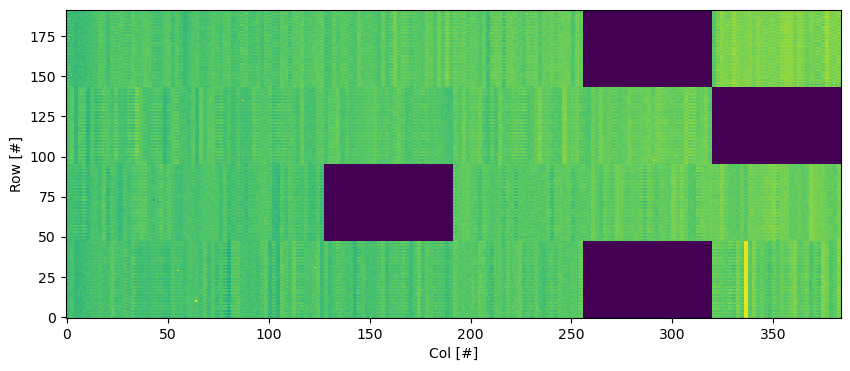

In [21]:
# Plot raw data and histogram

dataTimeAvg = np.average(data,axis=2)

print(np.shape(dataTimeAvg))

plt.figure(figsize = (10,4))
plt.imshow(dataTimeAvg, interpolation='none', aspect='auto', origin='lower', vmax=2**15)
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title("Raw data - Avg: {:.0f} - Reference pixel: {:.0f}".format(getMedianDark(data),dataTimeAvg[ref_row,ref_col]))
plt.colorbar()

plt.figure(figsize = (10,5))
plt.hist(data[:,:,0].flatten(), range=[0,2**15],bins=2**7, log=True)
plt.title("Distribution of dark values")
plt.ylabel("Entries [#]")
plt.xlabel("ADC Value [ADUs]")

444
Noise: 88.525947


Text(0.5, 0, 'Noise [ADUs]')

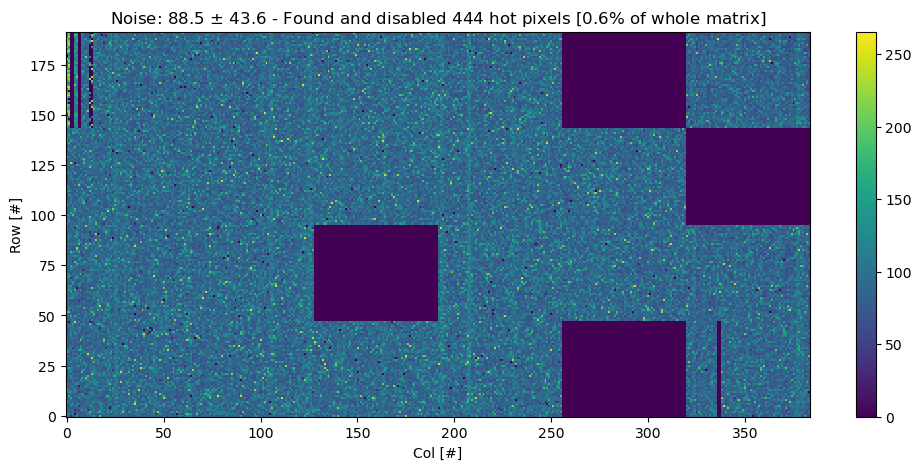

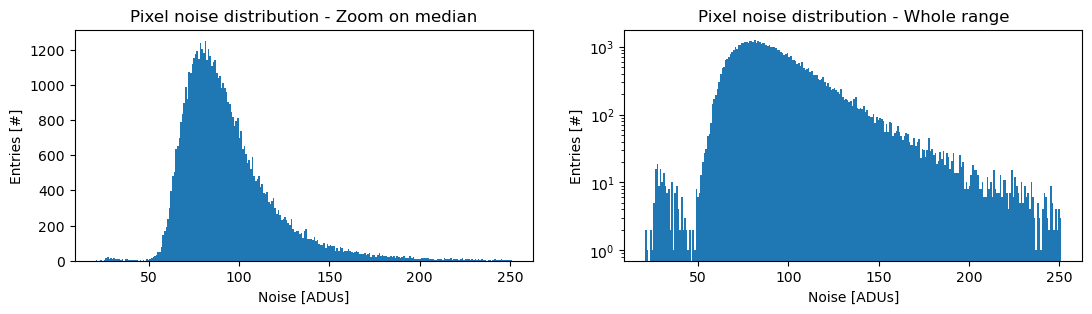

In [22]:
# Uncomment to filter bad pixels!

filterBad = True

if filterBad:
    data_filtered, numBadPixels = filter_bad_pixels(data,3)
else:
    data_filtered, numBadPixels = data, 0


print(numBadPixels)

# Calculate data_noisemap
data_noisemap = np.std(data_filtered, axis=2)

# Flatten array
noisemap_flat = data_noisemap.flatten()

# Remove 0 noise (lanes not locked)
noisemap_flat = noisemap_flat[noisemap_flat > 0]

median_noise = np.median(noisemap_flat)
std_noise    = np.percentile(noisemap_flat,84.135) - np.percentile(noisemap_flat,15.865)

# Get outliers (calculated as *2 noise)
noisemap_outliers = noisemap_flat[noisemap_flat > median_noise*2]

print('Noise: {:3f}'.format(median_noise))

# Top plot
plt.figure(figsize=(12,5))
plt.imshow(data_noisemap, interpolation='none', aspect='auto', vmin=0, vmax=median_noise*3, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title(r'Noise: {:.1f} $\pm$ {:.1f} - Found and disabled {:.0f} hot pixels [{:.1f}% of whole matrix]'.format(median_noise, std_noise, numBadPixels, numBadPixels*100/(192.0*384.0)))
plt.colorbar()

# Bottom plot
fig, ax = plt.subplots(1,2, figsize=(13,3))

ax[0].hist(data_noisemap[(data_noisemap < 400) & (data_noisemap > 1)].flatten(),bins=2**8)
ax[0].set_title("Pixel noise distribution - Zoom on median")
ax[0].set_ylabel("Entries [#]")
ax[0].set_xlabel("Noise [ADUs]")

ax[1].hist(data_noisemap[(data_noisemap > 1)].flatten(),bins=2**8,log=True)
ax[1].set_title("Pixel noise distribution - Whole range")
ax[1].set_ylabel("Entries [#]")
ax[1].set_xlabel("Noise [ADUs]")



# Common mode correction

In [ ]:
# Remove dark
dataCMcorr = data_filtered - np.median(data_filtered, axis=2, keepdims=True)
 
# Common mode correction on rows / whole image
dataCMcorr -= np.median(dataCMcorr, axis=(0,1), keepdims=True)
dataCMcorr -= np.median(dataCMcorr, axis=1, keepdims=True) # cols
dataCMcorr -= np.median(dataCMcorr, axis=0, keepdims=True) # rows 

# Calculate data_noisemap
data_noisemap = np.std(dataCMcorr, axis=2)

# Flatten array
noisemap_flat = data_noisemap.flatten()

# Remove 0 noise (lanes not locked)
noisemap_flat = noisemap_flat[noisemap_flat > 0]

median_noise = np.median(noisemap_flat)
std_noise    = np.percentile(noisemap_flat,84.135) - np.percentile(noisemap_flat,15.865)

# Get outliers (calculated as *2 noise)
noisemap_outliers = noisemap_flat[noisemap_flat > median_noise*2]

print('Noise: {:3f}'.format(median_noise))

# Top plot
plt.figure(figsize=(12,5))
plt.imshow(data_noisemap, interpolation='none', aspect='auto', vmin=0, vmax=median_noise*3, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title(r'Noise after CM correction: {:.1f} $\pm$ {:.1f} - Found and disabled {:.0f} hot pixels [{:.1f}% of whole matrix]'.format(median_noise, std_noise, numBadPixels, numBadPixels*100/(192.0*384.0)))
plt.colorbar()

# Bottom plot
fig, ax = plt.subplots(1,2, figsize=(13,3))

ax[0].hist(data_noisemap[(data_noisemap < 400) & (data_noisemap > 1)].flatten(),bins=2**8)
ax[0].set_title("Pixel noise distribution - Zoom on median")
ax[0].set_ylabel("Entries [#]")
ax[0].set_xlabel("Noise [ADUs]")

ax[1].hist(data_noisemap[(data_noisemap > 1)].flatten(),bins=2**8,log=True)
ax[1].set_title("Pixel noise distribution - Whole range")
ax[1].set_ylabel("Entries [#]")
ax[1].set_xlabel("Noise [ADUs]")

# Plot a dark-subtracted image

In [ ]:
# Subtract mean and display image
data_darksub = dataCMcorr - np.median(dataCMcorr, axis=2, keepdims=True)

plt.figure(figsize = (10,5))
plt.imshow(data_darksub[:,:,-1], interpolation='none', aspect='auto', vmin=-200, vmax=200, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title("Dark-subtracted image")
plt.colorbar()